# Molecular Spectral Latent Modelling
- Jan Andrzejczyk
- Marcel Wilanowicz

In [1]:
import selfies as sf
import pandas as pd

In [2]:
smi = 'COC'
selfie = sf.encoder(smi)
selfie

'[C][O][C]'

## Wczytanie i analiza struktury danych

In [3]:
''' Do wstępnej analizy załadowano losową próbkę k=10 plików, 
co odpowiada około 4% całego zbioru. '''

import random, glob, os, pandas as pd


DATA_DIR = "multimodal_spectroscopic_dataset"

# znajdź wszystkie pliki .parquet
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
print("Znaleziono plików:", len(paths))

# pobierz losową próbkę k=10
k = 10
sample_paths = random.sample(paths, k=k)

# wczytaj je i policz rekordy
dfs = []
rows_total = 0

for p in sample_paths:
    df = pd.read_parquet(p)
    dfs.append(df)
    print(os.path.basename(p), "->", len(df), "wierszy")
    rows_total += len(df)

data = pd.concat(dfs, ignore_index=True)

print("-" * 50)
print(f"Wczytano łącznie: {rows_total:,} rekordów z {k} plików.")
print("Średnia na plik:", rows_total / k)
print("Kolumny:", list(data.columns))

Znaleziono plików: 245
aligned_chunk_0.parquet -> 3235 wierszy
aligned_chunk_64.parquet -> 3229 wierszy
aligned_chunk_94.parquet -> 3225 wierszy
aligned_chunk_154.parquet -> 3234 wierszy
aligned_chunk_16.parquet -> 3276 wierszy
aligned_chunk_53.parquet -> 3214 wierszy
aligned_chunk_158.parquet -> 3288 wierszy
aligned_chunk_199.parquet -> 3290 wierszy
aligned_chunk_56.parquet -> 3205 wierszy
aligned_chunk_163.parquet -> 3245 wierszy
--------------------------------------------------
Wczytano łącznie: 32,441 rekordów z 10 plików.
Średnia na plik: 3244.1
Kolumny: ['smiles', 'hsqc_nmr_peaks', 'hsqc_nmr_spectrum', 'h_nmr_peaks', 'h_nmr_spectra', 'molecular_formula', 'c_nmr_peaks', 'ir_spectra', 'msms_positive_10ev', 'msms_positive_20ev', 'msms_positive_40ev', 'msms_fragments_positive', 'msms_negative_10ev', 'msms_negative_20ev', 'msms_negative_40ev', 'msms_fragments_negative', 'c_nmr_spectra']


W katalogu *multimodal_spectroscopic_dataset* znajduje się 245 plików w formacie .parquet.  
Losowa próbka 10 plików zawiera łącznie 32 441 rekordów (średnio ok. 3 200 rekordów na plik).  
Każdy rekord opisuje jedną cząsteczkę chemiczną i składa się z 17 kolumn:

| Kolumna | Opis |
|--------|------|
| smiles | struktura chemiczna w notacji SMILES |
| hsqc_nmr_peaks | lista pików widma HSQC NMR (pozycje 1H/13C, intensywności) |
| hsqc_nmr_spectrum | pełne widmo HSQC NMR w formie tablicy wartości |
| h_nmr_peaks | lista pików ¹H NMR (częstotliwości, integraly) |
| h_nmr_spectra | pełne widmo ¹H NMR jako wektor intensywności |
| molecular_formula | wzór sumaryczny cząsteczki (np. C19H9F5O4S) |
| c_nmr_peaks | lista pików ¹³C NMR |
| ir_spectra | widmo IR (absorbancja w funkcji liczby falowej) |
| msms_positive_10ev | widmo MS/MS w trybie dodatnim przy energii 10 eV |
| msms_positive_20ev | widmo MS/MS w trybie dodatnim przy energii 20 eV |
| msms_positive_40ev | widmo MS/MS w trybie dodatnim przy energii 40 eV |
| msms_fragments_positive | fragmenty jonów dodatnich z przypisanymi formułami |
| msms_negative_10ev | widmo MS/MS w trybie ujemnym przy energii 10 eV |
| msms_negative_20ev | widmo MS/MS w trybie ujemnym przy energii 20 eV |
| msms_negative_40ev | widmo MS/MS w trybie ujemnym przy energii 40 eV |
| msms_fragments_negative | fragmenty jonów ujemnych z przypisanymi formułami |
| c_nmr_spectra | pełne widmo ¹³C NMR |

### Wyjaśnienie terminologii

SMILES – tekstowa reprezentacja struktury chemicznej (atomy, wiązania, pierścienie zapisane jako ciąg znaków).

Molecular formula (wzór sumaryczny) – zlicza, ile atomów każdego pierwiastka zawiera cząsteczka (np. C15H12BrFN4).

NMR (nuclear magnetic resonance) – technika pozwalająca określić, jakie atomy znajdują się w cząsteczce i w jakim są otoczeniu chemicznym.  
- ¹H NMR – sygnały od protonów (atomów wodoru).  
- ¹³C NMR – sygnały od atomów węgla.  
- HSQC – widmo dwuwymiarowe ¹H–¹³C, które łączy protony z odpowiadającymi im atomami węgla.  
- Pik (peak) – pojedynczy sygnał w widmie.  
- Integral – obszar pod pikiem ¹H NMR; informuje, ile protonów daje dany sygnał.  
- Widmo (spectrum) – lista intensywności sygnału w funkcji częstotliwości (ppm).

IR (infrared spectroscopy) – widmo drgań cząsteczki; różne grupy funkcyjne pochłaniają promieniowanie IR w charakterystycznych miejscach, co pozwala je identyfikować.

MS/MS (tandem mass spectrometry) – technika, która rozbija cząsteczkę na fragmenty i mierzy ich masy.  
- m/z – stosunek masy do ładunku jonu.  
- Tryb dodatni/ujemny – sposób jonizacji (kationy lub aniony).  
- 10/20/40 eV – energia fragmentacji; wyższa energia daje więcej fragmentów.  
- Fragments – lista fragmentów z przypisanymi im formułami.

Każdy z tych typów danych pochodzi z innej techniki pomiarowej i opisuje inną właściwość tej samej cząsteczki. Zestaw zawiera tekstową strukturę, widma 1D, widma 2D, widma masowe oraz widmo IR, więc jest **multimodalny** (zawiera wiele modalności danych naraz).

In [4]:
import re

def count_elements(smiles):
    els = re.findall(r"[A-Z][a-z]?", smiles)
    return len(set(els))

data["n_elements"] = data["smiles"].map(count_elements)
data["is_organic"] = data["smiles"].str.contains("C")
data["smiles_len"] = data["smiles"].str.len()

print("Udział organicznych:", data["is_organic"].mean()*100)
print("Mediana długości SMILES:", data["smiles_len"].median())
print("Mediana liczby pierwiastków:", data["n_elements"].median())

Udział organicznych: 99.59310748743874
Mediana długości SMILES: 39.0
Mediana liczby pierwiastków: 4.0


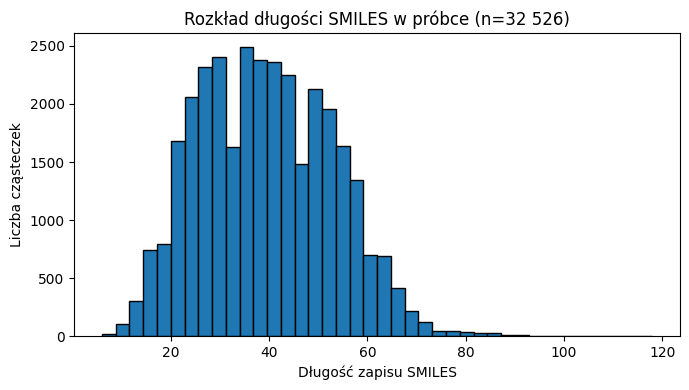

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(data["smiles_len"], bins=40, edgecolor="black")
plt.xlabel("Długość zapisu SMILES")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład długości SMILES w próbce (n=32 526)")
plt.tight_layout()
plt.savefig("smiles_length_hist.png", dpi=150)
plt.show()

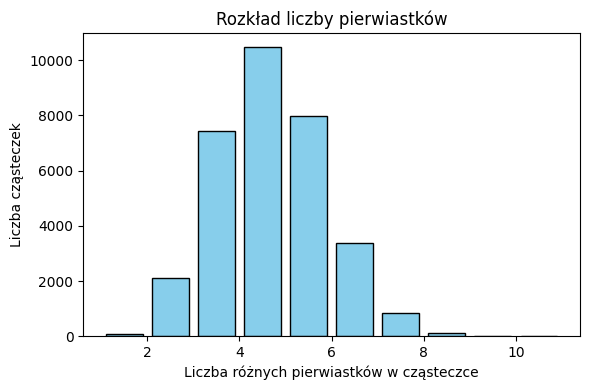

In [6]:
plt.figure(figsize=(6,4))
plt.hist(data["n_elements"].dropna(), bins=range(1,12), rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Liczba różnych pierwiastków w cząsteczce")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład liczby pierwiastków")
plt.tight_layout()
plt.savefig("num_elements_hist.png", dpi=150)
plt.show()

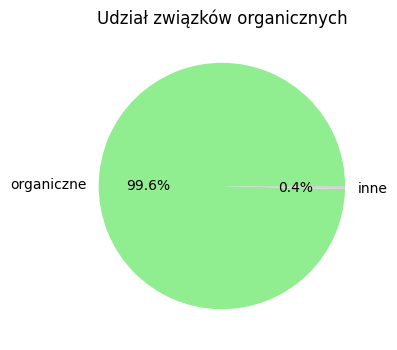

In [7]:
counts = data["is_organic"].value_counts()
plt.figure(figsize=(4,4))
plt.pie(counts, labels=["organiczne","inne"], autopct="%.1f%%", colors=["lightgreen","lightgray"])
plt.title("Udział związków organicznych")
plt.savefig("organic_pie.png", dpi=150)
plt.show()

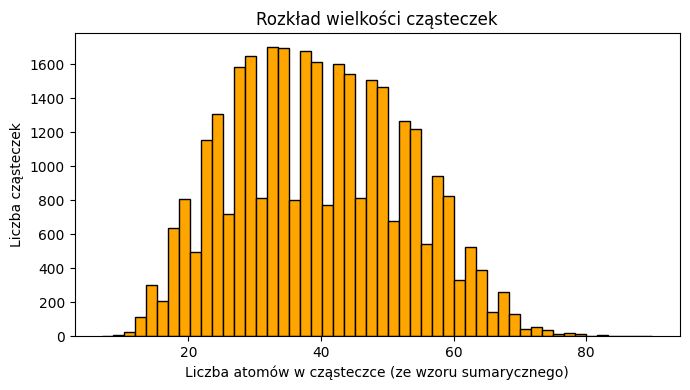

In [8]:
import re

def atom_count(formula):
    nums = re.findall(r"\d+", str(formula))
    return sum(map(int, nums)) if nums else None

data["atom_count"] = data["molecular_formula"].map(atom_count)

plt.figure(figsize=(7,4))
plt.hist(data["atom_count"].dropna(), bins=50, color="orange", edgecolor="black")
plt.xlabel("Liczba atomów w cząsteczce (ze wzoru sumarycznego)")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład wielkości cząsteczek")
plt.tight_layout()
plt.savefig("atom_count_hist.png", dpi=150)
plt.show()

Przykładowy SMILES:

In [9]:
med = data["smiles"].str.len().median()
one = data.iloc[(data["smiles"].str.len() - med).abs().argsort()[:1]][["smiles","molecular_formula"]]
print(one.to_dict(orient="records")[0])

{'smiles': 'CCC(=O)N(C)c1ccc2oc(-c3ccc(Cl)cc3)nc2c1', 'molecular_formula': 'C17H15ClN2O2'}


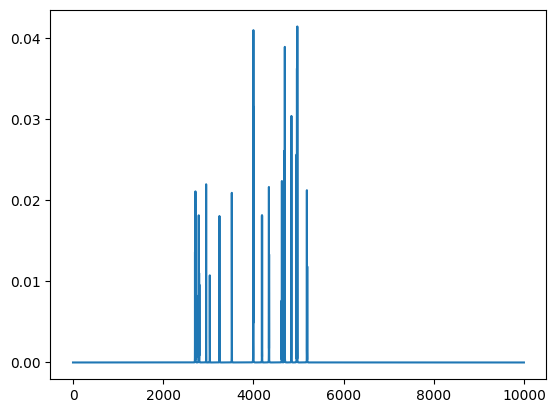

In [17]:
plt.plot(data["c_nmr_spectra"][0])

In [ ]:
df_selfies = pd.DataFrame()
df_selfies['smiles'] = data['smiles']
# TBD: convert SMILES to SELFIES and store in new csv file

In [22]:
smiles = list(data['smiles'])

for i in range(10):
    selfie = sf.encoder(smiles[i])
    print(selfie)

[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]
[C][N][Branch1][C][C][C][C][=C][C][=C][C][Branch2][Ring1][P][C][N][C][=C][C][=C][C][C][=Branch1][C][=O][NH1][N][=C][Branch1][=Branch1][C][Ring1][O][=Ring1][#Branch1][C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2]
[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Branch1][Ring1][C][O][C][=N][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring1][#Branch1][NH1][Ring1][#Branch2][C][=C][C][=C][Branch1][N][C][=Branch1][C][=O][N][C][C][=C][C][Ring1][Branch1][C][Branch1][C][Br][=C][Ring1][=C]
[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I][C][=N][Ring1][=Branch1][N][C][C][C][C][=C][Ring1][=Branch1][C][=N][N][Ring1][Branch1][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1]
[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C][Branch